In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
from utils import format_node_names

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path = Path('./system_analytics_2024/slurm_data/system_states')
files = sorted(list(folder_path.glob("*.txt")))[0:-1]
files

[PosixPath('system_analytics_2024/slurm_data/system_states/system_states_1.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_2.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_3.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_4.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_5.txt'),
 PosixPath('system_analytics_2024/slurm_data/system_states/system_states_6.txt')]

In [3]:

# files = ['system_states_1.txt', 'system_states_2.txt']

In [4]:

# for file_path in files:
def get_date_for_a_day(file_path):
    dict_list = []
    # file_path = folder_path / file
    with file_path.open(mode='r') as f:
        f_text = f.read()
    sinfo_day = f_text.split('############################')
    for sample_number in range(1, len(sinfo_day)-1):
        sinfo_sample = sinfo_day[sample_number].split('\n')
        time = sinfo_sample[1]
        for sample_row in range(4, len(sinfo_sample)-1):
            sample_row = np.random.randint(4, len(sinfo_sample)-1)
            node_number = int(sinfo_sample[sample_row].split()[7])
            state = sinfo_sample[sample_row].split()[8]
            node_names = sinfo_sample[sample_row].split()[-1]
            # print(format_node_names(node_names), node_number, state, time)
            d1 = {'node':format_node_names(node_names).split(','), 'time': [time] * node_number, 'state': [state]*node_number}
            dict_list.append(d1)
    df_list = [pd.DataFrame(d1) for d1 in dict_list]
    df = pd.concat(df_list, axis=0)
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values(['node', 'time'], inplace=True)
    return df
 
 


In [5]:
start_time = time.time()
with Pool(10) as pool:  # Initialize the pool with 4 processes
    parallel_results = pool.map(get_date_for_a_day, files)  # Submit tasks
parallel_duration = time.time() - start_time

In [6]:
df = pd.concat(parallel_results, axis=0)
df.sort_values(['node', 'time'], inplace=True)
display(df.head())
# why does duplication happen?
df.drop_duplicates(subset=['node', 'time', 'state'], inplace=True)

,node,time,state
0,fcn1,2024-11-04 17:03:13,mixed
0,fcn1,2024-11-04 17:03:13,mixed
0,fcn1,2024-11-04 17:03:43,mixed
0,fcn1,2024-11-04 17:03:43,mixed
0,fcn1,2024-11-04 17:03:43,mixed


In [7]:
print(f"Numebr of duplicated rows based on node and time: {df.duplicated(['node', 'time']).sum()}")
display(df.describe(include='all'), df['state'].value_counts())

Numebr of duplicated rows based on node and time: 0


,node,time,state
count,19700359,19700359,19700359
unique,1548,NaN,20
top,gcn48,NaN,allocated
freq,16538,NaN,9973509
mean,NaN,2024-11-07 17:31:33.012306432,NaN
min,NaN,2024-11-04 17:03:13,NaN
25%,NaN,2024-11-06 05:27:51,NaN
50%,NaN,2024-11-07 17:30:54,NaN
75%,NaN,2024-11-09 05:36:02,NaN
max,NaN,2024-11-10 17:54:36,NaN


state
allocated      9973509
idle           6311648
mixed          2884005
reserved        385184
drained          75988
planned          32240
completing       19663
draining         10705
drained*          3368
down*             1280
unknown           1173
inval             1095
idle*              267
mixed*              98
allocated*          54
reboot^             34
down                16
draining*           13
completing*         10
mixed-               9
Name: count, dtype: int64

In [8]:
# add node_type and removing not workers node
df['node_type'] = df['node'].str[0:3]
df = df[df['node_type'].isin(['fcn', 'gcn', 'tcn', 'hcn'])].copy()
# put the time in an intervale
df['time_5min_rounded'] = (df['time'] - pd.Timedelta('2.5min')).dt.round(freq='5min')
df['time_30min_rounded'] = (df['time'] - pd.Timedelta('15min')).dt.round(freq='30min')
df['time_hour_rounde'] = (df['time'] - pd.Timedelta('30min')).dt.round(freq='h')
df['time_6hour_rounde'] = (df['time'] - pd.Timedelta('3h')).dt.round(freq='6h')
df['time_day_rounded'] = (df['time'] - pd.Timedelta('12h')).dt.round(freq='d')
# get a sample
df.sample(n=10)

,node,time,state,node_type,time_5min_rounded,time_30min_rounded,time_hour_rounde,time_6hour_rounde,time_day_rounded
392,tcn447,2024-11-09 12:07:48,allocated,tcn,2024-11-09 12:05:00,2024-11-09 12:00:00,2024-11-09 12:00:00,2024-11-09 12:00:00,2024-11-09
17,tcn24,2024-11-05 11:31:53,allocated,tcn,2024-11-05 11:30:00,2024-11-05 11:30:00,2024-11-05 11:00:00,2024-11-05 06:00:00,2024-11-05
205,tcn216,2024-11-06 16:07:54,allocated,tcn,2024-11-06 16:05:00,2024-11-06 16:00:00,2024-11-06 16:00:00,2024-11-06 12:00:00,2024-11-06
9,gcn104,2024-11-05 10:39:32,allocated,gcn,2024-11-05 10:35:00,2024-11-05 10:30:00,2024-11-05 10:00:00,2024-11-05 06:00:00,2024-11-05
53,tcn61,2024-11-09 17:40:07,allocated,tcn,2024-11-09 17:40:00,2024-11-09 17:30:00,2024-11-09 17:00:00,2024-11-09 12:00:00,2024-11-09
163,tcn723,2024-11-08 12:20:00,allocated,tcn,2024-11-08 12:20:00,2024-11-08 12:00:00,2024-11-08 12:00:00,2024-11-08 12:00:00,2024-11-08
202,tcn234,2024-11-10 10:26:04,allocated,tcn,2024-11-10 10:25:00,2024-11-10 10:00:00,2024-11-10 10:00:00,2024-11-10 06:00:00,2024-11-10
3,tcn8,2024-11-10 15:50:50,idle*,tcn,2024-11-10 15:50:00,2024-11-10 15:30:00,2024-11-10 15:00:00,2024-11-10 12:00:00,2024-11-10
157,tcn1116,2024-11-07 09:33:16,allocated,tcn,2024-11-07 09:30:00,2024-11-07 09:30:00,2024-11-07 09:00:00,2024-11-07 06:00:00,2024-11-07
9,tcn181,2024-11-09 20:22:04,idle,tcn,2024-11-09 20:20:00,2024-11-09 20:00:00,2024-11-09 20:00:00,2024-11-09 18:00:00,2024-11-09


In [9]:
time_col = 'time_6hour_rounde'
df_temp = df.groupby(['node',time_col], as_index=False)['state'].value_counts(normalize=True)
df_temp.sort_values(['node', time_col], inplace=True)
df_temp.sample(n=10)

,node,time_6hour_rounde,state,proportion
28570,tcn295,2024-11-07 12:00:00,unknown,0.0016
56153,tcn930,2024-11-04 18:00:00,allocated,0.9571
37827,tcn504,2024-11-06 12:00:00,allocated,1.0000
7141,gcn2,2024-11-09 12:00:00,completing,0.0022
36891,tcn481,2024-11-07 18:00:00,allocated,1.0000
38011,tcn509,2024-11-07 18:00:00,planned,0.0098
7552,gcn26,2024-11-07 06:00:00,mixed,1.0000
56244,tcn932,2024-11-09 06:00:00,idle,1.0000
12061,tcn1011,2024-11-10 00:00:00,idle,1.0000
57609,tcn971,2024-11-07 12:00:00,idle,0.9978


In [10]:
# get the idle state only
df_idle = df_temp[(df_temp['state']=='idle')].copy()
df_idle.drop(columns='state', inplace=True)
df_idle.rename(columns={'proportion':'idle'}, inplace=True)
# get the not idle states and add their share
df_not_idle = df_temp[(df_temp['state']!='idle')].copy()
df_not_idle = df_not_idle.groupby(['node', time_col], as_index=False)['proportion'].sum().copy()
df_not_idle.rename(columns={'proportion':'not_idle'}, inplace=True)
# join the two data frame based on node and time
df_stat = pd.merge(df_idle, df_not_idle, how='outer', on=['node', time_col])
df_stat.fillna(value=0, inplace=True)
df_stat.sort_values(['node', time_col], inplace=True)
display(df_idle.tail(), df_not_idle.tail(), df_stat.tail())

,node,time_6hour_rounde,idle
58418,tcn999,2024-11-09 12:00:00,1.0
58419,tcn999,2024-11-09 18:00:00,1.0
58420,tcn999,2024-11-10 00:00:00,1.0
58421,tcn999,2024-11-10 06:00:00,1.0
58422,tcn999,2024-11-10 12:00:00,1.0


,node,time_6hour_rounde,not_idle
27402,tcn995,2024-11-07 12:00:00,0.0022
27403,tcn996,2024-11-07 12:00:00,0.0022
27404,tcn997,2024-11-07 12:00:00,0.0022
27405,tcn998,2024-11-07 12:00:00,0.0022
27406,tcn999,2024-11-07 12:00:00,0.0022


,node,time_6hour_rounde,idle,not_idle
38445,tcn999,2024-11-09 12:00:00,1.0,0.0
38446,tcn999,2024-11-09 18:00:00,1.0,0.0
38447,tcn999,2024-11-10 00:00:00,1.0,0.0
38448,tcn999,2024-11-10 06:00:00,1.0,0.0
38449,tcn999,2024-11-10 12:00:00,1.0,0.0


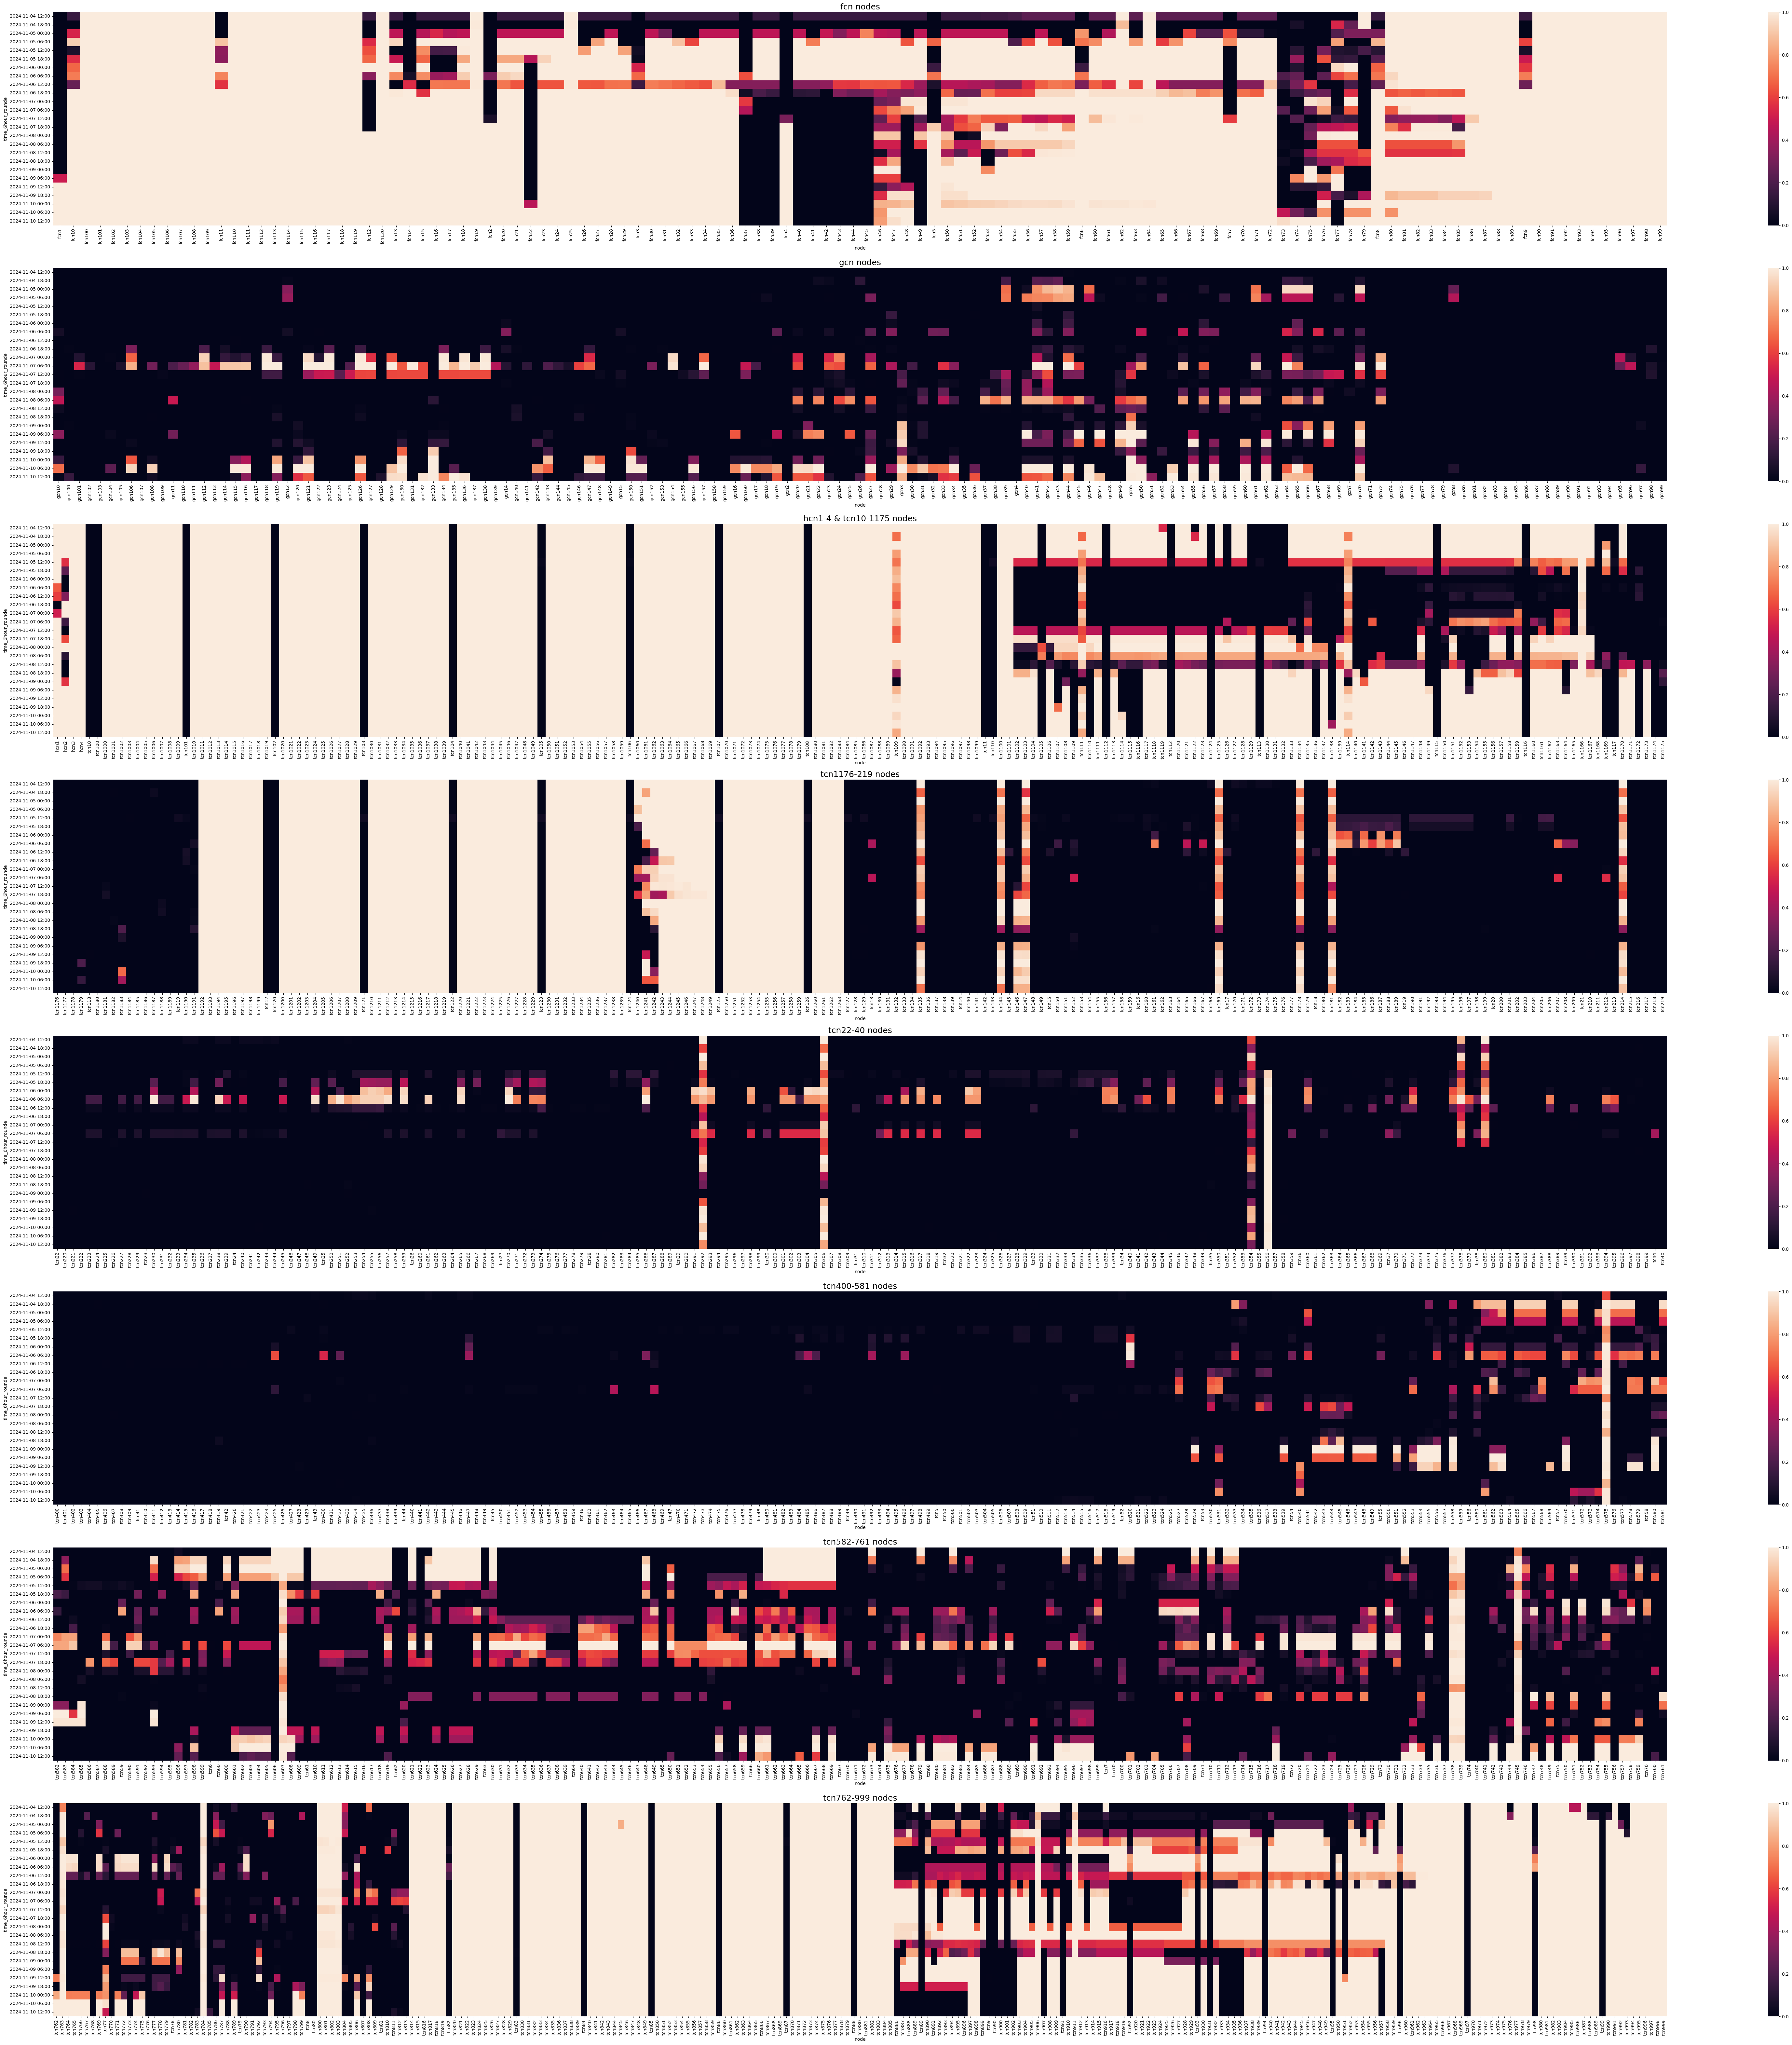

In [14]:
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))
# sns.heatmap(df_stat_pivot.iloc[:, 0:120], ax=ax[0])
# sns.heatmap(df_stat_pivot.iloc[:, 120:275], ax=ax[1])
# sns.heatmap(df_stat_pivot.iloc[:, 275:475], ax=ax[2])
# sns.heatmap(df_stat_pivot.iloc[:, 475:675], ax=ax[3])
# sns.heatmap(df_stat_pivot.iloc[:, 675:875], ax=ax[4])
# sns.heatmap(df_stat_pivot.iloc[:, 875:1075], ax=ax[5])
# sns.heatmap(df_stat_pivot.iloc[:, 1075:1275], ax=ax[6])
# sns.heatmap(df_stat_pivot.iloc[:, 1275:], ax=ax[7])




# # Create the main plot and set dimensions
# fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(80, 70))

# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]
titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_stat_pivot.iloc[:, start:end], ax=ax[i], vmin=0, vmax=1, xticklabels=True, yticklabels=True,
                cbar=True, cbar_kws={'orientation': 'vertical'})
    ax[i].set_title(title, fontsize=18)  # Set title for each subplot

# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Ensures everything fits within figure dimensions
plt.show()

In [12]:
ascending_node_names = df_stat_pivot.sum(axis=0).sort_values(ascending=True).index.to_list()
df_sorted_nodes = df_stat_pivot[ascending_node_names].copy()

df_sorted_nodes.head()

node               tcn90  tcn901  tcn99  tcn86  tcn29  tcn288  tcn28  tcn84  \
time_6hour_rounde                                                             
2024-11-04 12:00     0.0     0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-04 18:00     0.0     0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-05 00:00     0.0     0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-05 06:00     0.0     0.0    0.0    0.0    0.0     0.0    0.0    0.0   
2024-11-05 12:00     0.0     0.0    0.0    0.0    0.0     0.0    0.0    0.0   

node               tcn228  gcn103  tcn690  tcn702  tcn703  tcn741  tcn97  \
time_6hour_rounde                                                          
2024-11-04 12:00      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0     0.0     0.0    0.0   

node               tcn782  tcn324  tcn299  tcn740  gcn149  gcn158  gcn159  \
time_6hour_rounde                                                           
2024-11-04 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               gcn2  tcn321  tcn410  tcn130  tcn131  tcn408  tcn491  \
time_6hour_rounde                                                         
2024-11-04 12:00    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00    0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00    0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn490  tcn493  tcn495  tcn931  tcn497  tcn499  tcn115  \
time_6hour_rounde                                                           
2024-11-04 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0     0.0     0.0     0.0   

node               tcn391  tcn396  tcn500  tcn502  tcn1176  tcn48  tcn480  \
time_6hour_rounde                                                           
2024-11-04 12:00      0.0     0.0     0.0     0.0      0.0    0.0     0.0   
2024-11-04 18:00      0.0     0.0     0.0     0.0      0.0    0.0     0.0   
2024-11-05 00:00      0.0     0.0     0.0     0.0      0.0    0.0     0.0   
2024-11-05 06:00      0.0     0.0     0.0     0.0      0.0    0.0     0.0   
2024-11-05 12:00      0.0     0.0     0.0     0.0      0.0    0.0     0.0   

node               tcn482  tcn1178  tcn1177  tcn25  tcn1174  tcn523  tcn475  \
time_6hour_rounde                                                             
2024-11-04 12:00      0.0      0.0      0.0    0.0      0.0     0.0     0.0   
2024-11-04 18:00      0.0      0.0      0.0    0.0      0.0     0.0     0.0   
2024-11-05 00:00      0.0      0.0      0.0    0.0      0.0     0.0     0.0   
2024-11-05 06:00      0.0      0.0      0.0    0.0      0.0     0.0     0.0   
2024-11-05 12:00      0.0      0.0      0.0    0.0      0.0     0.0     0.0   

node               tcn26  tcn263  tcn179  tcn647  tcn65  tcn156  tcn39  \
time_6hour_rounde                                                        
2024-11-04 12:00     0.0     0.0     0.0     0.0    0.0     0.0  

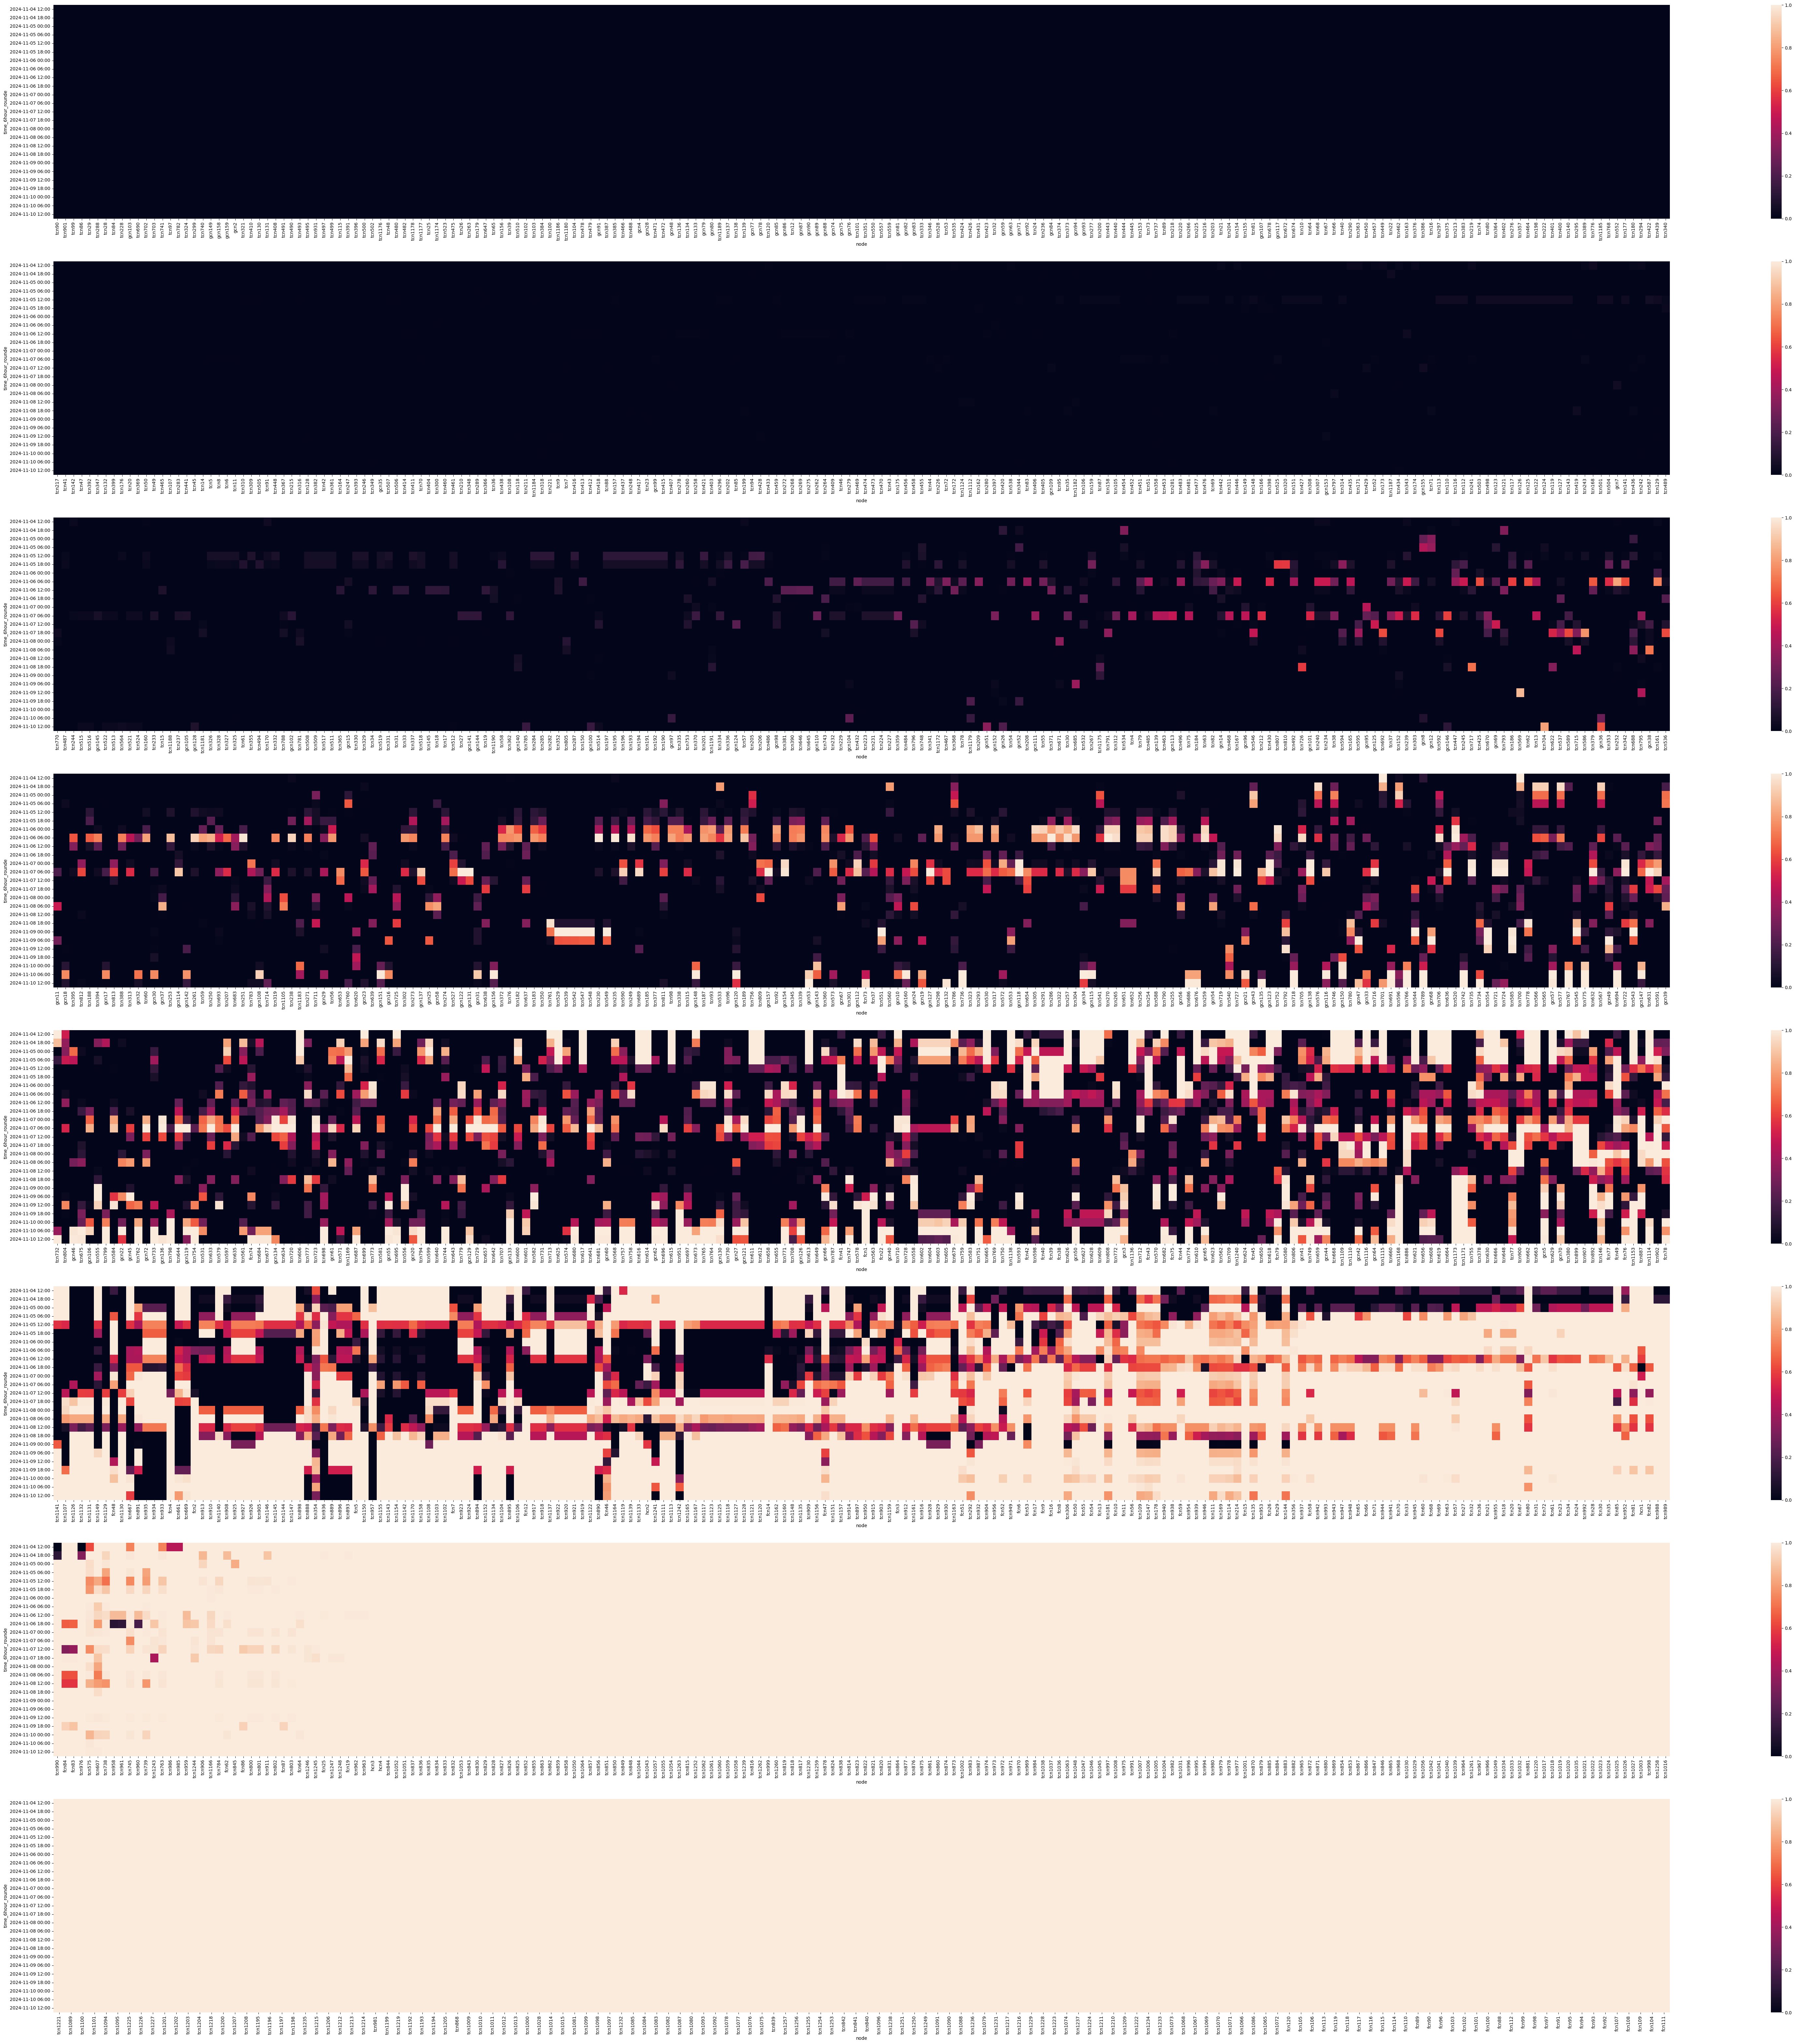

In [ ]:

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(80, 80))
ranges = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, None)]
titles = [
    "1-200 nodes",
    "200-400 nodes",
    "400-600 nodes",
    "600-800 nodes",
   "800-1000 nodes",
   "1000-1200 nodes",
   "1200-1400 nodes",
   "1400- nodes",
]

# Loop through each axis and range, adding heatmaps with a title for each
for i, ((start, end), title) in enumerate(zip(ranges, titles)):
    sns.heatmap(df_sorted_nodes.iloc[:, start:end], vmin=0, vmax=1,xticklabels=True, yticklabels=True,
                ax=ax[i], cbar=True, cbar_kws={'orientation': 'vertical'})
    # ax[i].set_title(title, fontsize=18)  # Set title for each subplot

# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Ensures everything fits within figure dimensions
plt.show()